In [ ]:
import numpy as np
import json
import tensorflow as tf
from google.protobuf import text_format
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential
from PIL import Image

import glob, os, random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# needed to install object_detection library and enlarge labels
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && cp /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf /usr/share/fonts/truetype/dejavu/arial.ttf

Cloning into 'models'...
remote: Enumerating objects: 68293, done.
remote: Total 68293 (delta 0), reused 0 (delta 0), pack-reused 68293
Receiving objects: 100% (68293/68293), 576.51 MiB | 14.11 MiB/s, done.
Resolving deltas: 100% (47983/47983), done.
cp: cannot stat '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf': No such file or directory


In [ ]:
# install object_detection library
! cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install --use-feature=2020-resolver .

Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 9.9 MB 6.9 MB/s 
     |████████████████████████████████| 352 kB 58.7 MB/s 
     |████████████████████████████████| 1.8 MB 45.2 MB/s 
     |████████████████████████████████| 23.1 MB 1.5 MB/s 
     |████████████████████████████████| 99 kB 8.1 MB/s 
     |████████████████████████████████| 47.7 MB 94 kB/s 
     |████████████████████████████████| 90 kB 7.7 MB/s 
     |████████████████████████████████| 1.1 MB 38.4 MB/s 
     |████████████████████████████████| 4.9 MB 51.1 MB/s 
     |████████████████████████████████| 213 kB 66.8 

In [ ]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2

In [ ]:
# reconstruct frozen graph
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

In [ ]:
# visualize detection
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=15)
            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/'
ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'annotations.json')
NCLASSES = 60

In [ ]:
!pwd
with open(ANNOTATIONS_FILE) as json_file:
    print(json_file)
    data = json.load(json_file)
    
categories = data['categories']

/content
<_io.TextIOWrapper name='/content/drive/MyDrive/Colab Notebooks/annotations.json' mode='r' encoding='UTF-8'>


In [ ]:
print('Building label map from examples')

labelmap = string_int_label_map_pb2.StringIntLabelMap()
for idx,category in enumerate(categories):
    item = labelmap.item.add()
    # label map id 0 is reserved for the background label
    item.id = int(category['id'])+1
    item.name = category['name']

with open('./labelmap.pbtxt', 'w') as f:
    f.write(text_format.MessageToString(labelmap))

print('Label map witten to labelmap.pbtxt')

with open('./labelmap.pbtxt') as f:
    print(f.readlines())

Building label map from examples
Label map witten to labelmap.pbtxt
['item {\n', '  name: "Aluminium foil"\n', '  id: 1\n', '}\n', 'item {\n', '  name: "Battery"\n', '  id: 2\n', '}\n', 'item {\n', '  name: "Aluminium blister pack"\n', '  id: 3\n', '}\n', 'item {\n', '  name: "Carded blister pack"\n', '  id: 4\n', '}\n', 'item {\n', '  name: "Other plastic bottle"\n', '  id: 5\n', '}\n', 'item {\n', '  name: "Clear plastic bottle"\n', '  id: 6\n', '}\n', 'item {\n', '  name: "Glass bottle"\n', '  id: 7\n', '}\n', 'item {\n', '  name: "Plastic bottle cap"\n', '  id: 8\n', '}\n', 'item {\n', '  name: "Metal bottle cap"\n', '  id: 9\n', '}\n', 'item {\n', '  name: "Broken glass"\n', '  id: 10\n', '}\n', 'item {\n', '  name: "Food Can"\n', '  id: 11\n', '}\n', 'item {\n', '  name: "Aerosol"\n', '  id: 12\n', '}\n', 'item {\n', '  name: "Drink can"\n', '  id: 13\n', '}\n', 'item {\n', '  name: "Toilet tube"\n', '  id: 14\n', '}\n', 'item {\n', '  name: "Other carton"\n', '  id: 15\n', '}\n'

In [ ]:
label_map = label_map_util.load_labelmap('labelmap.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [ ]:
detection_graph = reconstruct("/content/drive/MyDrive/Colab Notebooks/ssd_mobilenet_v2_taco_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


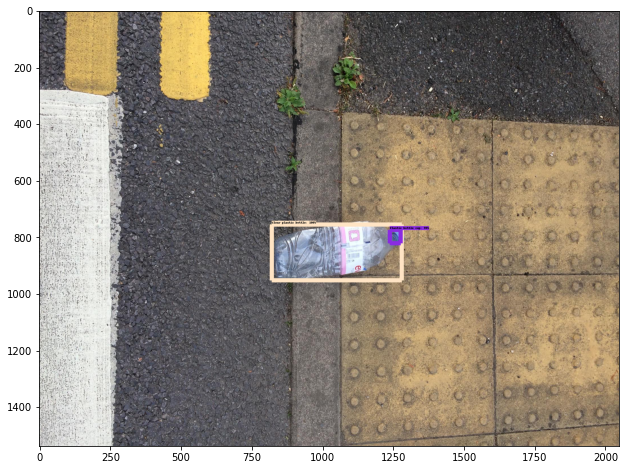

In [ ]:
detect(detection_graph, '/content/drive/MyDrive/Colab Notebooks/1.jpg')

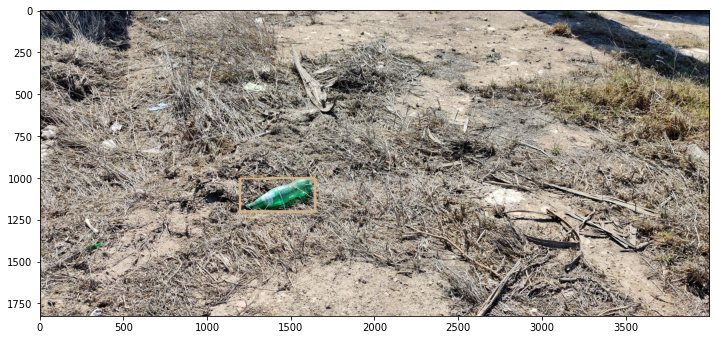

In [ ]:
detect(detection_graph, '/content/drive/MyDrive/Colab Notebooks/2.jpg')